Frame enumuration and submission to Hyp3 with Tropo, Iono, SET corrections.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from s1_frame_enumerator import (get_s1_stack, 
                                 filter_s1_stack_by_geometric_coverage_per_pass, 
                                 get_global_s1_frames, 
                                 get_overlapping_s1_frames, 
                                 enumerate_dates, 
                                 frames2gdf, 
                                 enumerate_gunw_time_series)
from shapely.geometry import Point
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import warnings
import json
import pandas as pd
import datetime

In [3]:
AOI_NAME = 'Aleutian' #'Los Angeles' # 'Hawaii'
WEATHER_MODEL = 'GMAO'

In [4]:
if WEATHER_MODEL == 'HRRR':
    assert 'Los-Angeles' in AOI_NAME

In [5]:
GEO_DICT = {'Los-Angeles-0':  Point(-118, 34).buffer(1),
            'Los-Angeles-1':  Point(-118, 34).buffer(1),
            'Hawaii-0': Point(-155.5, 19.5).buffer(1),
            'Hawaii-1': Point(-155.5, 19.5).buffer(1),
            'Norfolk': Point(-76.5, 36.4).buffer(1),
            'Somalia': Point(41, 1.5).buffer(1),
            'Tibet': Point(92, 41.5).buffer(1),
            'Norway': Point(13, 65).buffer(1),
            'Aleutian': Point(-177, 52).buffer(.25),
            }

TRACK_DICT = {'Los-Angeles-0': [64],
              'Los-Angeles-1': [71],
              'Hawaii-0': [124],
              'Hawaii-1': [87],
              'Norfolk': [4],
              'Somalia': [87],
              'Tibet': [48],
              'Norway': [37],
              'Aleutian': [59],
              }

In [6]:
aoi_geo = GEO_DICT[AOI_NAME]
track_numbers = TRACK_DICT[AOI_NAME]

df_aoi = gpd.GeoDataFrame(geometry=[aoi_geo], crs=CRS.from_epsg(4326))

In [7]:
frames = get_overlapping_s1_frames(aoi_geo, track_numbers=track_numbers)

In [8]:
# There will be lots of ways to do this more efficiently i.e. only include frames with overlap of a land mask
# Even to be more confident would likely want some percentage
# Currently, we just shrunk our AOI and excluded a frame
if AOI_NAME == 'Aleutian':
    frames = list(filter(lambda f: f.frame_id!= 9101, frames))

In [9]:
df_frames_all = frames2gdf(frames)
df_frames_all.head()

,frame_id,hemisphere,track_number_min,track_number_max,geometry
0,9102,None,59,59,"POLYGON Z ((-179.25232 51.11341 0.00000, -179...."


<Axes: >

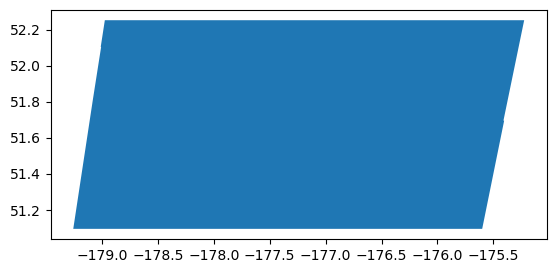

In [10]:
df_frames_all.plot()

(50.094426525795875, 53.25164802620814)

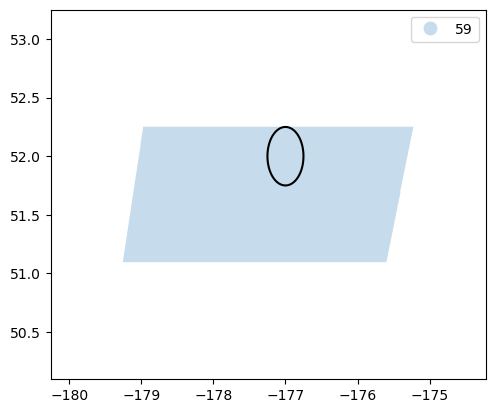

In [11]:
fig, ax = plt.subplots()
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.boundary.plot(ax=ax)
df_frames_by_track = df_frames_all.dissolve(by='track_number_min').reset_index(drop=False)
df_frames_by_track.plot(ax=ax, 
                        column='track_number_min',
                        categorical=True,
                        alpha=.25, 
                        legend=True)
df_aoi.boundary.plot(ax=ax, edgecolor='black')
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

(50.094426525795875, 53.25164802620814)

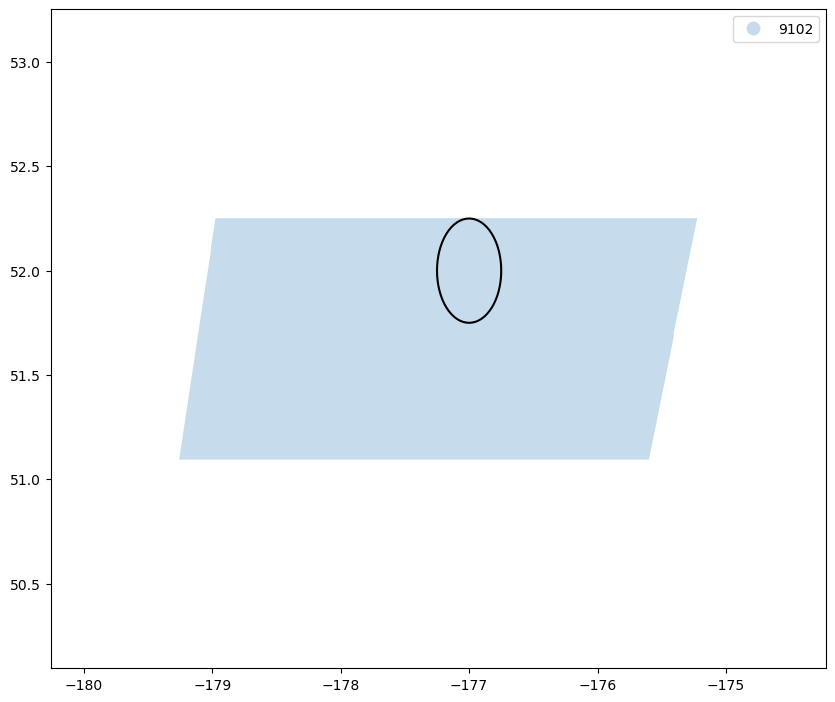

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.boundary.plot(ax=ax)
df_frames_all.plot(ax=ax, 
                   column='frame_id', 
                   alpha=.25,
                   categorical=True,
                   legend=True)
df_aoi.boundary.plot(ax=ax, edgecolor='black')

xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

# Get Stack from Frame

Here a stack is a list of images with metadata and extents. We note the stack here is not arbitrarily constructed and at some point might be nice to create a simple class to encapsulate it. However, here a stack is one that can be organized to do interferometry over the frames.

1. Per pass coverage $\geq 80$% as it pertains to the frame's coverage geometry
2. Contiguous coverage through frames (determined as Polygon object)

Requires:

1. Frames to be contiguous (otherwise 2. does not make sense)
2. Requires single track or two sequential tracks (we only check if the track numbers are sequential)

In [13]:
df_stack = get_s1_stack(frames)
df_stack.head()

,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,stack_repeat_pass_id,repeat_pass_timestamp,geometry
0,S1B_IW_SLC__1SSV_20161016T180136_20161016T1802...,2016-10-16 18:01:36+00:00,2016-10-16 18:02:06+00:00,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,59,VV,2535,IW,2.253735,7,2016-10-16 00:00:00+00:00,"POLYGON ((-175.77722 50.56355, -175.19310 52.3..."
1,S1B_IW_SLC__1SSV_20161109T180136_20161109T1802...,2016-11-09 18:01:36+00:00,2016-11-09 18:02:06+00:00,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,59,VV,2885,IW,2.591868,8,2016-11-09 00:00:00+00:00,"POLYGON ((-175.77622 50.56342, -175.19191 52.3..."
2,S1B_IW_SLC__1SSV_20161203T180135_20161203T1802...,2016-12-03 18:01:35+00:00,2016-12-03 18:02:05+00:00,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,59,VV,3235,IW,2.673943,9,2016-12-03 00:00:00+00:00,"POLYGON ((-175.19183 52.34723, -178.85074 52.7..."
3,S1B_IW_SLC__1SSV_20161227T180135_20161227T1802...,2016-12-27 18:01:35+00:00,2016-12-27 18:02:04+00:00,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,59,VV,3585,IW,2.770986,10,2016-12-27 00:00:00+00:00,"POLYGON ((-175.19333 52.34503, -178.85202 52.7..."
4,S1B_IW_SLC__1SSV_20170120T180133_20170120T1802...,2017-01-20 18:01:33+00:00,2017-01-20 18:02:02+00:00,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,59,VV,3935,IW,2.529571,11,2017-01-20 00:00:00+00:00,"POLYGON ((-175.19035 52.34661, -178.84909 52.7..."


# Select N Dates from stack

To make sure there is weather model availability, we are going to truncate the stack to dates on or before `2022-03-01`.

In [14]:
if AOI_NAME == 'Tibet':
    N = 5
else:
    N = 3

# Give ourselves 1 year buffer
MAX_DATE = pd.Timestamp('2022-03-01', tz='UTC')
df_stack_f = df_stack[df_stack.repeat_pass_timestamp <= MAX_DATE]

dates = sorted(df_stack_f.repeat_pass_timestamp.unique(), reverse=True)
df_stack_f = df_stack_f[df_stack_f.repeat_pass_timestamp >= dates[N]].reset_index(drop=True)
df_stack_f.head()

,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,stack_repeat_pass_id,repeat_pass_timestamp,geometry
0,S1A_IW_SLC__1SDV_20170619T180219_20170619T1802...,2017-06-19 18:02:19+00:00,2017-06-19 18:02:49+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,59,VV+VH,17106,IW,4.279134,21,2017-06-19 00:00:00+00:00,"POLYGON ((-175.19369 52.34633, -178.85167 52.7..."
1,S1A_IW_SLC__1SDV_20170701T180219_20170701T1802...,2017-07-01 18:02:19+00:00,2017-07-01 18:02:49+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,59,VV+VH,17281,IW,4.290374,22,2017-07-01 00:00:00+00:00,"POLYGON ((-175.19292 52.34592, -178.85089 52.7..."
2,S1A_IW_SLC__1SDV_20170713T180220_20170713T1802...,2017-07-13 18:02:20+00:00,2017-07-13 18:02:50+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,59,VV+VH,17456,IW,4.301014,23,2017-07-13 00:00:00+00:00,"POLYGON ((-175.19328 52.34641, -178.85132 52.7..."
3,S1A_IW_SLC__1SDV_20180403T180221_20180403T1802...,2018-04-03 18:02:21+00:00,2018-04-03 18:02:51+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,59,VV+VH,21306,IW,4.387327,44,2018-04-03 00:00:00+00:00,"POLYGON ((-175.77760 50.56439, -175.19341 52.3..."


# Generate Pairs

In [15]:
min_temporal_baseline = 0
neighbors = 2

data = enumerate_gunw_time_series(df_stack_f, 
                                  min_temporal_baseline, 
                                  n_secondary_scenes_per_ref=neighbors,
                                  frames=frames 
                                 )

Date Pairs: 100%|█| 5/5 [00:00<00:00, 40.


In [16]:
len(data)

5

In [17]:
data[0]

{'reference': ['S1A_IW_SLC__1SDV_20180403T180221_20180403T180251_021306_024A9A_2DF1'],
 'secondary': ['S1A_IW_SLC__1SDV_20170713T180220_20170713T180250_017456_01D2CE_6B7E'],
 'reference_date': Timestamp('2018-04-03 00:00:00+0000', tz='UTC'),
 'secondary_date': Timestamp('2017-07-13 00:00:00+0000', tz='UTC'),
 'frame_id': 9102,
 'geometry': <POLYGON Z ((-179.252 51.113 0, -179.081 51.813 0, -179.008 52.103 0, -179.0...>}

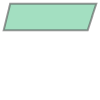

In [18]:
data[0]['geometry']

# Hyp3

In [19]:
TRACKS = ",".join([str(t) for t in TRACK_DICT[AOI_NAME]])
TODAY = datetime.datetime.now().date().strftime('%m%d')
AOI_TOKEN = AOI_NAME.replace(' ', '-')
JOB_NAME = '_'.join([AOI_TOKEN, TRACKS, WEATHER_MODEL, TODAY])
f'JOB_NAME: {JOB_NAME}'

'JOB_NAME: Aleutian_59_GMAO_0321'

In [20]:
f'JOB_NAME character length: {len(JOB_NAME)}'

'JOB_NAME character length: 21'

In [21]:
assert len(JOB_NAME) <= 30

In [22]:
job_parameters =  [{'granules': ifg_data['reference'],
                    'secondary_granules': ifg_data['secondary'],
                    'weather_model': WEATHER_MODEL,
                    'estimate_ionosphere_delay': True,
                    'compute_solid_earth_tide': True,
                    'frame_id': ifg_data['frame_id'],
                     } for ifg_data in data]
job_parameters[:2]

[{'granules': ['S1A_IW_SLC__1SDV_20180403T180221_20180403T180251_021306_024A9A_2DF1'],
  'secondary_granules': ['S1A_IW_SLC__1SDV_20170713T180220_20170713T180250_017456_01D2CE_6B7E'],
  'weather_model': 'GMAO',
  'estimate_ionosphere_delay': True,
  'compute_solid_earth_tide': True,
  'frame_id': 9102},
 {'granules': ['S1A_IW_SLC__1SDV_20180403T180221_20180403T180251_021306_024A9A_2DF1'],
  'secondary_granules': ['S1A_IW_SLC__1SDV_20170701T180219_20170701T180249_017281_01CD86_8A37'],
  'weather_model': 'GMAO',
  'estimate_ionosphere_delay': True,
  'compute_solid_earth_tide': True,
  'frame_id': 9102}]

In [23]:
job_dicts = [{'name': JOB_NAME,
              # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
              'job_type': 'INSAR_ISCE_TEST',
              'job_parameters': parameters
             }
             for parameters in job_parameters]
job_dicts[:2]

[{'name': 'Aleutian_59_GMAO_0321',
  'job_type': 'INSAR_ISCE_TEST',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20180403T180221_20180403T180251_021306_024A9A_2DF1'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20170713T180220_20170713T180250_017456_01D2CE_6B7E'],
   'weather_model': 'GMAO',
   'estimate_ionosphere_delay': True,
   'compute_solid_earth_tide': True,
   'frame_id': 9102}},
 {'name': 'Aleutian_59_GMAO_0321',
  'job_type': 'INSAR_ISCE_TEST',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20180403T180221_20180403T180251_021306_024A9A_2DF1'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20170701T180219_20170701T180249_017281_01CD86_8A37'],
   'weather_model': 'GMAO',
   'estimate_ionosphere_delay': True,
   'compute_solid_earth_tide': True,
   'frame_id': 9102}}]

In [24]:
len(job_dicts)

5

You may want to use `prompt=True` to toggle between Earthdata accounts.

In [25]:
import hyp3_sdk

# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-a19-jpl.asf.alaska.edu')

Uncomment this to submit jobs:

In [26]:
# submitted_jobs = hyp3_isce.submit_prepared_jobs(job_dicts[:])

These are useful snippets to inspect status and view metadata.

In [27]:
jobs = hyp3_isce.find_jobs(name=JOB_NAME)
print(jobs)

0 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 0 pending.


In [28]:
# jobs[0].to_dict()

In [29]:
# successful_jobs = hyp3_isce.find_jobs(name=JOB_NAME, status_code='SUCCEEDED')
# dicts_success = [j.to_dict() for j in successful_jobs]
# dicts_success[:]

In [30]:
# urls = [d['files'][0]['url'] for d in dicts_success]
# urls

In [31]:
# failed_jobs = hyp3_isce.find_jobs(name=JOB_NAME, status_code='FAILED')
# dicts_failed = [j.to_dict() for j in failed_jobs]
# dicts_failed[:]

In [32]:
# all_jobs = hyp3_isce.find_jobs(name=JOB_NAME)
# dicts_all = [j.to_dict() for j in all_jobs]
# dicts_all[:]